# Classification of Red Wine Quality

## 1. 데이터 불러오기

In [49]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder

data= pd.read_csv("C:/Users/min/Documents/SocialCom/WineClass/winequality-red.csv")

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import f1_score,recall_score,precision_score
from sklearn.ensemble import RandomForestClassifier


import warnings
warnings.filterwarnings('ignore')

palette = sns.color_palette("Spectral")

## 2. 데이터 전처리

### 2.1 null & 중복 rows 처리

In [51]:
def deal_with_nulls_and_duplicates( df , drop_na = False ):
    
    # missing data
    if drop_na is True:
        df.dropna(inplace=True)
    
    else:
        for col in df.columns:
        
            # 절반 이상이 nan인 열을 drop columns
            if df[col].isna().sum()/len(df) > 0.5 :
                df.drop(columns=col , inplace = True)
        
            # null 채우기
            elif df[col].dtype =="float":
                df[col] = df[col].fillna(df[col].mean())
            
            elif df[col].dtype =="int":
                df[col] = df[col].fillna(df[col].median())
            
            elif df[col].dtype =="object":
                df[col] = df[col].fillna(df[col].mode())
            
    # 중복 rows를 제거
    df.drop_duplicates(inplace=True)
    
    return df

In [52]:
data = deal_with_nulls_and_duplicates(data ,drop_na= False)

### 2.2 outliers와 skewness 처리
일변량분석 결과 
- fixed acidity,sulphates, chlorides는 약간 우측 왜도
- Density, pH는 정상 분포를 띰
- alcohol, citric acid 등의 특성은 정상분포가 아님

In [53]:
def deal_with_outliers(df , columns = None):
    
    if columns is None:
        columns = df.select_dtypes(include=['number']).drop(columns= "quality").columns

    for col in columns:
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        
        # outliers를 column의 중앙값/평균으로 대체
        if df[col].dtype =="int":
            
            df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = np.nan
            df[col].fillna(df[col].median(), inplace=True)
            
        elif df[col].dtype =="float":
            
            df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = np.nan
            df[col].fillna(df[col].mean(), inplace=True)
            
    return df.head()

In [54]:
deal_with_outliers(data, columns=['residual sugar','chlorides','volatile acidity'])

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


outlier와 skewness의 영향력을 줄이기 위해 log transformer 사용

In [55]:
for col in ['fixed acidity','total sulfur dioxide','free sulfur dioxide','sulphates','alcohol']:
    data[col]=np.log(data[col])

In [56]:
data["quality"] = (data["quality"] > 6.5).astype(int)

**위 코드가 성능을 60%대에서 90%대로 상승시킴**

## 3. 모델 구축

1. 데이터 split
2. 반복
3. 평가
4. results

### 3.1 데이터 split
- 데이터를 train용과 test용으로 분리한다.

In [57]:
target = "quality"
X = data.drop(columns=target)
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1087, 11)
y_train shape: (1087,)
X_test shape: (272, 11)
y_test shape: (272,)


### 3.2 반복(Iterate)
#### (1) 앙상블 기법 중 하나인 **랜덤 포레스트** 활용

In [59]:
RF_classifer = RandomForestClassifier()
RF_classifer.fit(X_train,y_train)

RF_y_pred = RF_classifer.predict(X_test)

print('Model accuracy score with criterion entropy: {:0.2%}'. format(accuracy_score(y_test, RF_y_pred)))

Model accuracy score with criterion entropy: 92.28%


#### (2) K-Fold 교차검증
- 교차검증(cross-validation) 기법 중 가장 많이 사용되는 것
- 교차검증을 통해 과적합을 예방/완화할 수 있다.
- **cv**: KFold 교차검증에서 K의 개수(몇 개의 폴드로 나눌 것인가)  

- **n_jobs**: 본 기계학습에서 사용할 코어 수, 사용하는 CPU 코어 개수에 비례해서 훈련 속도가 빨라짐 (-1: 컴퓨터의 모든 코어 사용)
- **verbose**: 각 iteration에서 메세지 출력 개수 (default: 0)

In [60]:
cv_acc_scores = cross_val_score(RF_classifer, X_train, y_train ,cv =5 ,n_jobs=-1)
print(cv_acc_scores)

[0.87614679 0.86238532 0.87096774 0.83870968 0.86175115]


**(3) 그리드 서치** 모델 사용  
**Why Grid Search?**
- 하이퍼 파라미터에 넣을 수 있는 값들을 순차적으로 입력한 뒤에 가장 높은 성능을 보이는 하이퍼 파라미터들을 찾는 탐색 방법
- 그리드 서치의 **하이퍼파라미터**
- **n_estimators**: 트리의 개수
- **max_depth**: 최대 트리 깊이

In [61]:
params = {
    "n_estimators":range(50,200,50),
    "max_depth":range(0,50,10)  
}
model = GridSearchCV(
    RF_classifer,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1)
model

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(0, 50, 10),
                         'n_estimators': range(50, 200, 50)},
             verbose=1)

In [62]:
model.fit(X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(0, 50, 10),
                         'n_estimators': range(50, 200, 50)},
             verbose=1)

In [63]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001395,0.000488,0.000000,0.000000,0,50,"{'max_depth': 0, 'n_estimators': 50}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
1,0.001993,0.000630,0.000000,0.000000,0,100,"{'max_depth': 0, 'n_estimators': 100}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
2,0.001197,0.000746,0.000000,0.000000,0,150,"{'max_depth': 0, 'n_estimators': 150}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
3,0.247138,0.049181,0.010970,0.000631,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.885321,0.857798,0.884793,0.834101,0.861751,0.864753,0.019087,12
4,0.505049,0.054303,0.028723,0.019559,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.889908,0.862385,0.884793,0.838710,0.875576,0.870274,0.018346,4


In [64]:
print(model.best_params_)
print("-------------")
print(model.best_score_)
print("-------------")
print(model.best_estimator_)

{'max_depth': 20, 'n_estimators': 150}
-------------
0.873035132964106
-------------
RandomForestClassifier(max_depth=20, n_estimators=150)


In [65]:
acc_train = model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9228


In [66]:
precision = precision_score(y_test, model.predict(X_test), average='weighted')

In [67]:
print("Precision: {:.4f}".format(precision))

Precision: 0.9201


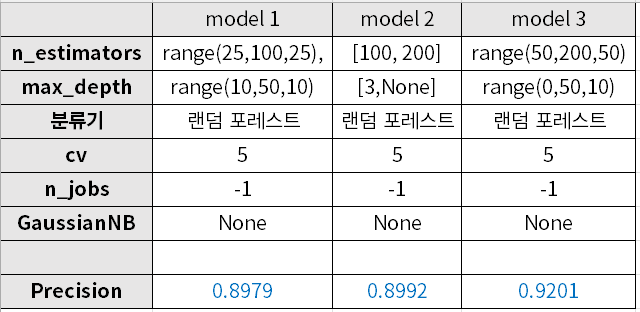